# Raytracing of single spherical facet

#### Stephen Fegan
#### sfegan@llr.in2p3.fr
#### 2013-07-06

This notebook develops a semi-analytic ray tracing of a single spherical facet. The general approach is that of Vassiliev, Fegan & Brousseau (Astroparticle Physics, 28, 10, 2007; hereafter VFB), section 2. The incoming rays are traced to the focal plane and the moments of the light distribution calculated by integration. Unlike VFB, the  integration is done numerically rather than by expansions. 

The more general ray-tracing code, from which the majority of the results in this note have been derived, is validated against these results by running it with a single facet.

**Update 2016-07-13:** update for inclusion in *calin*

In [1]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = 9, 6
from numpy import *
import scipy.integrate

Populating the interactive namespace from numpy and matplotlib


## Development of semi-analytic method

Following the methodology described in section 2 of Vassiliev, Fegan & Brousseau (Astroparticle Physics, 28, 10, 2007; hereafter VFB), we derive the tangential and sagittal PSF of a single spherical mirror facet with radius of curvature $R$ and diameter $D$ at an image plane at distance $F$. The surface is defined as:

\\[ \vec{r}(\phi,\theta) = R\\,\left(\begin{array}{c} \sin\theta\cos\phi \\\\ \sin\theta\sin\phi \\\\ 1-\cos\theta \end{array}\right\) \\]

where $\theta\in[0,\sin^{-1}(D/2R)]$ and $\phi\in[0,2\pi]$. 

The normal for each point on the facet is:

\\[ \vec{n}(\phi,\theta) = \left(\begin{array}{c} -\sin\theta\cos\phi \\\\ -\sin\theta\sin\phi \\\\ \cos\theta \end{array}\right) \\]

As in VFB, we define the direction of an incoming ray from infinity as,

\\[ \vec{g} = \left(\begin{array}{c} \sin\delta \\\\ 0 \\\\ -\cos\delta \end{array}\right) \\]

and the reflected ray therefore has direction,

\\[ \vec{s}(\phi,\theta) = \vec{g} - 2\left(\vec{g}\cdot\vec{n}(\phi,\theta)\right)\\,\vec{n}(\phi,\theta) \\]

The reflected ray crosses the focal plane at,

\\[ \vec{r}_{fp}(\phi,\theta) = F\\,\left(\begin{array}{c} x(\phi,\theta) \\\\ y(\phi,\theta) \\\\ 1 \end{array}\right) = \vec{r}(\phi,\theta) + t \vec{s}(\phi,\theta) \\]

The z-component can be solved to give $t$, and hence $(x,y)$. 

The relevent moments of the light distribution on the focal plane, i.e. the mean and variances in the tangential (x) and sagittal (y) directions ($\hat{x},\hat{y},\sigma^2_x,\sigma^2_y$) can be calculate by integrating:

\\[ \mathcal{I}[f(\phi,\theta)] = \int_0^{\sin^{-1}(D/2R)} \int_0^{2\pi} f(\phi,\theta) \left|\vec{g}\cdot\vec{n}(\phi,\theta)\right| R^2\sin\theta d\theta d\phi \\]

where the term $\left|\vec{g}\cdot\vec{n}(\phi,\theta)\right|$ accounts for inclination of the facet with respect to the beam.

For example, the mean and variances in the tangential plane are:

\\[ \hat{x} = \frac{\mathcal{I}[x(\phi,\theta)]}{\mathcal{I}[1]}\ \ \textrm{and}\ \ \sigma^2_x = \frac{\mathcal{I}[x^2(\phi,\theta)]}{\mathcal{I}[1]} - \hat{x}^2 \\]

These integrals can be done by expansions (as in VFB) or numerically. Code to evaluate them numerically using the SciPy quadrature double integration routine is presented below.

In [2]:
def r(t,p,R,F): # Position on reflector of facet at theta,phi
    return R*array([sin(t)*cos(p), sin(t)*sin(p), 1-cos(t)])

def n(t,p,R,F): # Normal of facet at theta,phi
    return array([-sin(t)*cos(p), -sin(t)*sin(p), cos(t)]);

def s(t,p,g,R,F): # Direction of ray reflected from facet at theta,phi
    _n = n(t,p,R,F)
    # Note: return vector is not normlized
    return g - 2*dot(g,_n)*_n   
    
def r_fp(t,p,g,R,F): # Position on focal plane of ray reflected from facet at theta,phi
    _r = r(t,p,R,F)
    _s = s(t,p,g,R,F)
    tfp = (F-_r[2])/_s[2]
    return (_r+tfp*_s)/F

def integrate(fn,g,R,F,D,p0=0): # Integral of parallel beam over full reflector
    integrand = lambda t,p: -(R**2)*sin(t)*fn(t,p)*dot(n(t,p,R,F),g)
    gfun = lambda p: 0
    hfun = lambda p: arcsin(D/cos(mod(p+p0,pi/3)-pi/6)/2.0/R)
    return scipy.integrate.dblquad(integrand,0,2*pi,gfun,hfun)

### Illustration of focal-plane images

In [3]:
F = 1600.
R = 1607. * 2.0
D = 120.

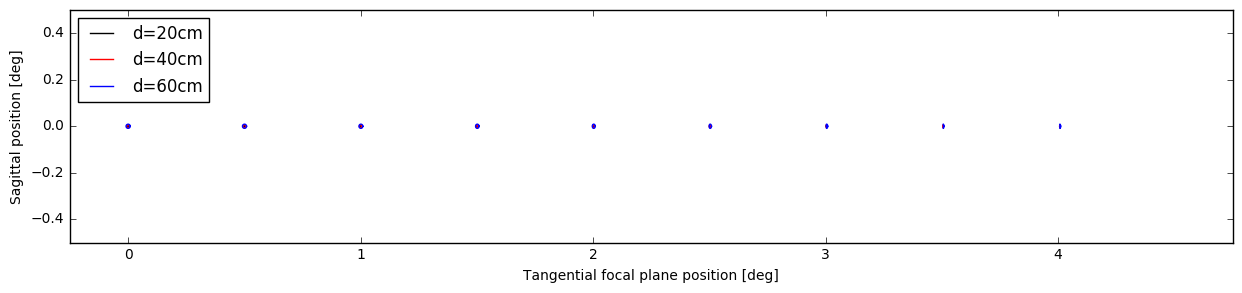

In [4]:
d = 4.0/180.0*pi

figure(1,figsize=[15,3])
labset=False
C = [ 'k','r','b' ]
for d in arange(0,4.01,0.5)/180.0*pi:
    g = array([sin(d), 0, -cos(d)])
    for i in range(0,3):
        Di = D*float(i+1)/3.0/2.0
        t = Di/R
        p = arange(0.0,360.1,1)/180.0*pi
        rfp = list(map(lambda _p: r_fp(t,_p,g,R,F),p))
        x = array(list(map(lambda _r: _r[0]/pi*180, rfp)))
        y = array(list(map(lambda _r: _r[1]/pi*180, rfp)))
        lab = "_NOLABEL_"
        if labset==False:
            lab = 'd=%.0fcm'%Di
        plot(x,y,C[i],label=lab)
    labset = True
axis([-0.25, 4.75, -.5, .5]);
xlabel('Tangential focal plane position [deg]')
ylabel('Sagittal position [deg]')
legend(loc=2);

In [5]:
def calcPSF_SA(dv, R, F, D):
    meanxv = []
    meanyv = []
    rmsxv = []
    rmsyv = []

    for d in dv:
        v = array([sin(d), 0, -cos(d)])

        int1  = integrate(lambda t,p: 1,v,R,F,D)
        intx  = integrate(lambda t,p: r_fp(t,p,v,R,F)[0],v,R,F,D)
        inty  = integrate(lambda t,p: r_fp(t,p,v,R,F)[1],v,R,F,D)
        intxx = integrate(lambda t,p: r_fp(t,p,v,R,F)[0]**2,v,R,F,D)
        intyy = integrate(lambda t,p: r_fp(t,p,v,R,F)[1]**2,v,R,F,D)

        meanx = intx[0]/int1[0]
        meany = inty[0]/int1[0]

        varx = intxx[0]/int1[0] - meanx**2
        vary = intyy[0]/int1[0] - meany**2

        meanxv.append(meanx)
        meanyv.append(meany)
        rmsxv.append(sqrt(varx))
        rmsyv.append(sqrt(vary))
    
    meanx = array(meanxv)
    meany = array(meanyv)
    rmsx = array(rmsxv)
    rmsy = array(rmsyv)
    
    return meanx, meany, rmsx, rmsy

In [6]:
dv = arange(0.0,20.01,0.25)/180.0*pi
meanx_sa, meany_sa, rmsx_sa, rmsy_sa = calcPSF_SA(dv,R,F,D)

In [7]:
import sys,os
from calin.simulation.vs_optics import *
import calin.math.vector3d_util
from numpy import *

In [8]:
def calcPSF_RT(dv, R, F, D, N=100000):
    param = calin.ix.simulation.vs_optics.IsotropicDCArrayParameters()
    param.mutable_prescribed_array_layout().add_scope_positions();
    dc = param.mutable_reflector()
    dc.set_curvature_radius(R)
    dc.set_aperture(D)
    dc.set_facet_spacing(D)
    dc.set_facet_size(dc.facet_spacing())
    dc.set_facet_focal_length(R/2.0)
    dc.mutable_psf_align().set_object_plane(inf);
    dc.set_alignment_image_plane(F)
    dc.set_weathering_factor(1.0)
    dc.set_facet_spot_size_probability(0.8)
    dc.set_facet_spot_size(0)
    param.mutable_focal_plane().mutable_translation().set_y(F)
    param.mutable_pixel().set_spacing(1)
    param.mutable_pixel().set_cone_inner_diameter(1)
    param.mutable_pixel().set_cone_survival_prob(1)

    rng = calin.math.rng.RNG()
    cta = calin.simulation.vs_optics.VSOArray()
    cta.generateFromArrayParameters(param, rng)
    scope = cta.telescope(0)
    
    print(scope.numMirrors(), scope.numPixels())
    
    PS = 1/scope.focalPlanePosition()[1]

    raytracer = calin.simulation.vs_optics.VSORayTracer(cta, rng)
    ph = calin.math.ray.Ray()
    info = calin.simulation.vs_optics.VSOTraceInfo()

    beam_dir = scope.opticalAxis()
    beam_dir *= -1.0
    beam_cen = asarray([0,0,0])

    meanxv = []
    meanyv = []
    rmsxv = []
    rmsyv = []
    for d in dv:
        beam_dir_offset = \
            calin.math.vector3d_util.rotate_angle_axis(beam_dir, d, asarray([1,0,0]));
        x = []
        y = []
        for i in range(0,N):
            raytracer.laserBeam(ph, beam_cen, beam_dir_offset, -1.0*scope.curvatureRadius(), D/cos(30.0/180.*pi)*0.52, 300)
            pixel = raytracer.trace(ph, info, scope)
            if info.rayHitFocalPlane():
                x.append(info.fplane_z)
                y.append(info.fplane_x)
        x = array(x)*PS
        y = array(y)*PS
    
        meanxv.append(mean(x))
        meanxv.append(mean(y))
        rmsxv.append(std(x))
        rmsyv.append(std(y))

    meanx = array(meanxv)
    meany = array(meanyv)
    rmsx  = array(rmsxv)
    rmsy  = array(rmsyv)
    
    return meanx, meany, rmsx, rmsy

In [9]:
dv2 = arange(0.0,20.01,1.0)/180.0*pi
meanx_rt, meany_rt, rmsx_rt, rmsy_rt = calcPSF_RT(dv2,R,F,D,N=100000)

1 1


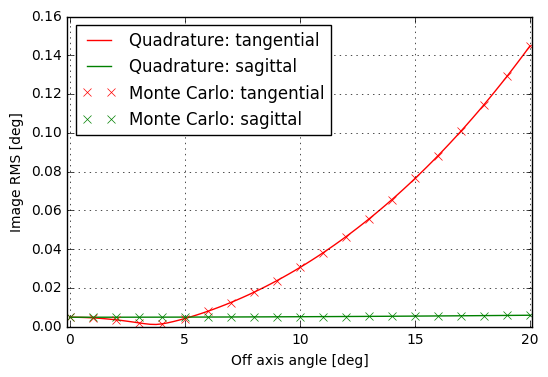

In [10]:
figure(figsize=(6,4))
plot(dv/pi*180,rmsx_sa/pi*180,'r-',label='Quadrature: tangential')
plot(dv/pi*180,rmsy_sa/pi*180,'g-',label='Quadrature: sagittal')
#plot(dv/pi*180,rmsx_sa_c/pi*180,'r-')
#plot(dv/pi*180,rmsy_sa_c/pi*180,'g-')
plot(dv2/pi*180,rmsx_rt/pi*180,'rx',label='Monte Carlo: tangential')
plot(dv2/pi*180,rmsy_rt/pi*180,'gx',label='Monte Carlo: sagittal')
xlabel('Off axis angle [deg]')
ylabel('Image RMS [deg]')
legend(loc=2)
axis(array(axis())+array([-0.1, 0.1, 0, 0]))
grid()
#gcf().savefig('single_facet_rms.pdf',bbox_inches='tight')

In [11]:
meanx_sa_x10, meany_sa_x10, rmsx_sa_x10, rmsy_sa_x10 = calcPSF_SA(dv,R,F,D*10.0)
meanx_rt_x10, meany_rt_x10, rmsx_rt_x10, rmsy_rt_x10 = calcPSF_RT(dv2,R,F,D*10.0,N=100000)

1 1


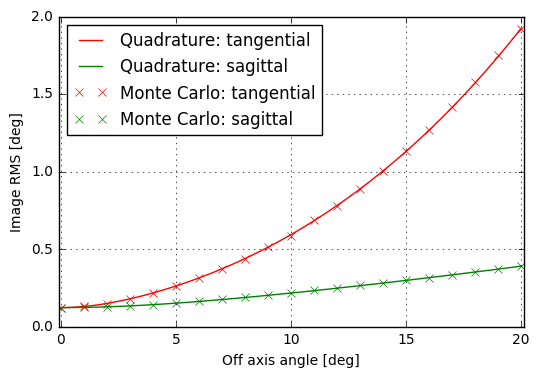

In [12]:
figure(figsize=(6,4))
plot(dv/pi*180,rmsx_sa_x10/pi*180,'r-',label='Quadrature: tangential')
plot(dv/pi*180,rmsy_sa_x10/pi*180,'g-',label='Quadrature: sagittal')
#plot(dv/pi*180,rmsx_sa_c/pi*180,'r-')
#plot(dv/pi*180,rmsy_sa_c/pi*180,'g-')
plot(dv2/pi*180,rmsx_rt_x10/pi*180,'rx',label='Monte Carlo: tangential')
plot(dv2/pi*180,rmsy_rt_x10/pi*180,'gx',label='Monte Carlo: sagittal')
xlabel('Off axis angle [deg]')
ylabel('Image RMS [deg]')
legend(loc=2)
axis(array(axis())+array([-0.1, 0.1, 0, 0]))
grid()
#gcf().savefig('single_facet_x10_rms.pdf',bbox_inches='tight')

In [13]:
#numpy.savez('single_facet.npz',dv,meanx_sa,meany_sa,rmsx_sa,rmsy_sa,dv2,meanx_rt, meany_rt, rmsx_rt, rmsy_rt,meanx_sa_x10, meany_sa_x10, rmsx_sa_x10, rmsy_sa_x10,meanx_rt_x10, meany_rt_x10, rmsx_rt_x10, rmsy_rt_x10)